In [1]:
library(ggplot2)
library(dplyr)
library(stringr)
library(ggplot2)
library(tidyverse)
setwd('/data1/HTT_APA/170828_D00331_0257_BCBC0YANXX_Pugh_Laura/MAAPER_out_2/')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
# functions 

volcano_plot_2 <- function(fit, x, xlab = "Ln fold change", y, ylab = "-Log10 FDR",
    title = "LMCN data, metastatic vs non-metastatic", titleLabSize = 12, border = "full",
    pCutoff = 0.001, FCcutoff = 1.5, xlim = c(-3, 3), ylim = c(0, 10), pointsize= .2, top_n) {

    if (! x %in% names(fit)){
        stop(print(paste('The column', x, 'does not exist in the given dataframe.')))
    }

    if (! y %in% names(fit)){
        stop(print(paste('The column', y, 'does not exist in the given dataframe.')))
    }

    return(EnhancedVolcano::EnhancedVolcano(fit, lab = fit['transcript'], selectLab=top_n, x=x, xlab=xlab, y=y, ylab=ylab, title=title,
    titleLabSize=titleLabSize, border=border, pCutoff=pCutoff, FCcutoff=FCcutoff, xlim=xlim, ylim=ylim, pointSize=pointsize))
}

nmor_factor <- function (expression.data.frame, data.columns){
  gm_mean_z <- function(x){
    exp(sum(log(x)) / length(x))
  }
  edf <- expression.data.frame
  id.names <- names(edf)
  geo.mean.vec <- apply(edf[,data.columns], 1, function(x) gm_mean_z(x))
  ratios.df <- edf[,data.columns]/geo.mean.vec
  # Division by 0 gm_mean will create NAs here.
  normalization.factors <- apply(ratios.df, 2, function(x) median(x, na.rm=TRUE))
  return(normalization.factors)
}


count_pas <- function(genes,pas){
    c1_counts <- genes %>% select(contains('c1')) %>% mutate(C1_Allcounts=rowSums(.))  
    c2_counts <- genes %>% select(contains('c2')) %>% mutate(C2_Allcounts=rowSums(.), gene_name=genes$gene) 
    counts_table <- data.frame(c1_counts['C1_Allcounts'], c2_counts['C2_Allcounts'], c2_counts['gene_name'])
    colnames(pas) <- c('gene_name', 'pas', 'type', 'frac.c1', 'frac.c2')
    new_df <- inner_join(pas, counts_table, by="gene_name")
    new_df <- new_df %>% mutate(DMSO_PAcount=C1_Allcounts*frac.c1, LILY283_PAcount=C2_Allcounts*frac.c2)
    return(new_df)
}

In [5]:
genes_file <- read.csv("gene.txt", sep='\t')
pas_file <- read.csv("pas.txt", sep='\t')
out_file <- "pas_counts.txt"
df <- count_pas(genes_file, pas_file)
# df <- df %>% filter(gene_name=='HTT')
writfe.table(df, file=out_file, quote=F, sep='\t', row.names = F)
head(df)

,gene_name,pas,type,frac.c1,frac.c2,C1_Allcounts,C2_Allcounts,DMSO_PAcount,LILY283_PAcount
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,PLEKHN1,chr1:975865:+,3' most exon,0.455,0.357,571,443,259.805,158.151
2,PLEKHN1,chr1:975231:+,3' most exon,0.545,0.643,571,443,311.195,284.849
3,B3GALT6,chr1:1234959:+,3' most exon,0.354,0.280,4313,5896,1526.802,1650.880
4,B3GALT6,chr1:1234058:+,3' most exon,0.174,0.132,4313,5896,750.462,778.272
5,B3GALT6,chr1:1233729:+,3' most exon,0.472,0.588,4313,5896,2035.736,3466.848
6,MIB2,chr1:1630605:+,3' most exon,0.628,0.576,1199,1267,752.972,729.792


In [6]:
inp_df <- read.csv('pas_counts.txt', sep='\t')
out_file <-"APAlog_pas_count_input.txt"
head(inp_df)

,gene_name,pas,type,frac.c1,frac.c2,C1_Allcounts,C2_Allcounts,DMSO_PAcount,LILY283_PAcount
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,PLEKHN1,chr1:975865:+,3' most exon,0.455,0.357,571,443,259.805,158.151
2,PLEKHN1,chr1:975231:+,3' most exon,0.545,0.643,571,443,311.195,284.849
3,B3GALT6,chr1:1234959:+,3' most exon,0.354,0.280,4313,5896,1526.802,1650.880
4,B3GALT6,chr1:1234058:+,3' most exon,0.174,0.132,4313,5896,750.462,778.272
5,B3GALT6,chr1:1233729:+,3' most exon,0.472,0.588,4313,5896,2035.736,3466.848
6,MIB2,chr1:1630605:+,3' most exon,0.628,0.576,1199,1267,752.972,729.792


In [7]:
sf <- nmor_factor(inp_df, c(8:9))
sf

DMSO_PAcount LILY283_PAcount 
       0.798569        1.252252

In [8]:
out_df <- inp_df %>% mutate(DMSO = DMSO_PAcount/sf[1], LILY283 = LILY283_PAcount/sf[2])
head(out_df)

,gene_name,pas,type,frac.c1,frac.c2,C1_Allcounts,C2_Allcounts,DMSO_PAcount,LILY283_PAcount,DMSO,LILY283
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,PLEKHN1,chr1:975865:+,3' most exon,0.455,0.357,571,443,259.805,158.151,325.3382,126.2932
2,PLEKHN1,chr1:975231:+,3' most exon,0.545,0.643,571,443,311.195,284.849,389.6908,227.4693
3,B3GALT6,chr1:1234959:+,3' most exon,0.354,0.280,4313,5896,1526.802,1650.880,1911.9225,1318.3286
4,B3GALT6,chr1:1234058:+,3' most exon,0.174,0.132,4313,5896,750.462,778.272,939.7585,621.4978
5,B3GALT6,chr1:1233729:+,3' most exon,0.472,0.588,4313,5896,2035.736,3466.848,2549.2300,2768.4900
6,MIB2,chr1:1630605:+,3' most exon,0.628,0.576,1199,1267,752.972,729.792,942.9016,582.7835


In [9]:
out_df_2 <- out_df %>% gather(sample, normalized_count, `LILY283`:`DMSO`) %>% arrange(pas, type, sample)
head(out_df_2)

,gene_name,pas,type,frac.c1,frac.c2,C1_Allcounts,C2_Allcounts,DMSO_PAcount,LILY283_PAcount,sample,normalized_count
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>
1,SLC35A3,chr1:100015692:+,Intron,0.3290,0.4680,504,983,165.8160,460.0440,DMSO,207.64142
2,SLC35A3,chr1:100015692:+,Intron,0.3290,0.4680,504,983,165.8160,460.0440,LILY283,367.37325
3,SLC35A3,chr1:100023451:+,3' most exon,0.2490,0.2470,504,983,125.4960,242.8010,DMSO,157.15111
4,SLC35A3,chr1:100023451:+,3' most exon,0.2490,0.2470,504,983,125.4960,242.8010,LILY283,193.89144
5,SLC35A3,chr1:100023553:+,3' most exon,0.0928,0.0519,504,983,46.7712,51.0177,DMSO,58.56877
6,SLC35A3,chr1:100023553:+,3' most exon,0.0928,0.0519,504,983,46.7712,51.0177,LILY283,40.74075


In [10]:
write.table(out_df_2, file=out_file, quote=F, sep='\t', row.names = F)   

In [11]:
## lets install the APAlog
# BiocManager::install("Goodarzilab/APAlog", dependencies = TRUE)
library(APAlog)

Registered S3 methods overwritten by 'ggalt':
  method                  from   
  grid.draw.absoluteGrob  ggplot2
  grobHeight.absoluteGrob ggplot2
  grobWidth.absoluteGrob  ggplot2
  grobX.absoluteGrob      ggplot2
  grobY.absoluteGrob      ggplot2



In [12]:
## make a simle design table and run it for AST-PP table
design_table <- data.frame(sample=c('DMSO', 'LILY283'),
                           Condition=c('DMSO_control','LILY283_treatment'))
design_table$sample <- factor(design_table$sample, levels=c('DMSO', 'LILY283'))
design_table$Condition <- factor(design_table$Condition, levels=c('DMSO_control', 'LILY283_treatment'))
head(design_table)

,sample,Condition
,<fct>,<fct>
1,DMSO,DMSO_control
2,LILY283,LILY283_treatment


In [13]:
pA_test_table <- out_df_2[, c(1,2,10,11)]
colnames(pA_test_table) <- c('transcript', 'pA.site','sample','count')
head(pA_test_table)

,transcript,pA.site,sample,count
,<chr>,<chr>,<chr>,<dbl>
1,SLC35A3,chr1:100015692:+,DMSO,207.64142
2,SLC35A3,chr1:100015692:+,LILY283,367.37325
3,SLC35A3,chr1:100023451:+,DMSO,157.15111
4,SLC35A3,chr1:100023451:+,LILY283,193.89144
5,SLC35A3,chr1:100023553:+,DMSO,58.56877
6,SLC35A3,chr1:100023553:+,LILY283,40.74075


In [30]:
pA_test_table$sample <- factor(pA_test_table$sample, levels=c('DMSO', 'LILY283'))
pA_test_table$transcript <- factor(pA_test_table$transcript)
pA_test_table$pA.site <- factor(pA_test_table$pA.site)

pA_test_table[sapply(pA_test_table, is.character)] <- lapply(pA_test_table[sapply(pA_test_table, is.character)], 
                                       as.factor)
head(pA_test_table)

,transcript,pA.site,sample,count
,<fct>,<fct>,<fct>,<dbl>
1,SLC35A3,chr1:100015692:+,DMSO,207.64142
2,SLC35A3,chr1:100015692:+,LILY283,367.37325
3,SLC35A3,chr1:100023451:+,DMSO,157.15111
4,SLC35A3,chr1:100023451:+,LILY283,193.89144
5,SLC35A3,chr1:100023553:+,DMSO,58.56877
6,SLC35A3,chr1:100023553:+,LILY283,40.74075


In [35]:
pA_test_table_2 <- pA_test_table %>% filter(transcript %in% c('HTT'))
pA_test_table_2

transcript,pA.site,sample,count
<fct>,<fct>,<fct>,<dbl>
HTT,chr4:3122753:+,DMSO,30.830900
HTT,chr4:3122753:+,LILY283,111.989413
HTT,chr4:3123822:+,DMSO,8.373528
HTT,chr4:3123822:+,LILY283,70.247904
HTT,chr4:3124024:+,DMSO,7.041921
HTT,chr4:3124024:+,LILY283,59.974495
HTT,chr4:3125021:+,DMSO,37.189023
HTT,chr4:3125021:+,LILY283,124.946865
HTT,chr4:3240659:+,DMSO,548.238177


In [32]:
fit.o_test_HTT <- APAlog::pA_logit_dev(pA_test_table_2,
                                     pA.site ~ Condition,
                                     design_table,
                                     "sample",  
                                     adj_method = "fdr")
fit.o_test_HTT <- fit.o_test_HTT %>% filter(transcript=='HTT')

fit.o_test_HTT

[1] "99.98393703317% of transcripts had <2 active pA sites and were removed"


transcript,p_devtest,fdr_p_devtest
<fct>,<dbl>,<dbl>
HTT,1,1


In [21]:
fit.op_test <- merge(fit.o_test, fit.p_test, by = "transcript")
fit.op_test

transcript,p_devtest,fdr_p_devtest,ref_site,alt_site,b_intercept,p_intercept,b_ConditionLILY283_treatment,p_ConditionLILY283_treatment
<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
A4GALT,1.376434e-07,1.099411e-06,chr22:42692121:-,chr22:42718249:-,-1.6214863,3.728691e-30,1.03307731,1.812541e-07
AAAS,1.396403e-02,4.208194e-02,chr12:53298803:-,chr12:53307509:-,1.0511726,4.823962e-64,0.21449381,1.395909e-02
AACS,1.506460e-01,3.267191e-01,chr12:125140928:+,chr12:125143316:+,1.7663246,1.407950e-78,0.20730097,1.521752e-01
AADAT,2.255014e-03,8.422626e-03,chr4:170060271:-,chr4:170060673:-,-2.4879187,1.072704e-43,0.23133162,3.375452e-01
AADAT,2.255014e-03,8.422626e-03,chr4:170060271:-,chr4:170075271:-,-1.7768338,4.167490e-42,-1.36580411,7.976691e-07
AADAT,2.255014e-03,8.422626e-03,chr4:170060673:-,chr4:170075271:-,0.7110849,7.335367e-04,-1.59713573,6.198980e-06
AAED1,1.861869e-03,7.118539e-03,chr9:96639577:-,chr9:96641251:-,1.9277485,2.440848e-182,-0.28432670,1.903038e-03
AAGAB,8.207535e-04,3.427603e-03,chr15:67201028:-,chr15:67201672:-,1.8693177,9.581450e-173,0.33976217,2.472764e-04
AAGAB,8.207535e-04,3.427603e-03,chr15:67201028:-,chr15:67202774:-,-0.5394574,1.349102e-07,-0.10900699,4.555713e-01


In [36]:
fit.p_test_HTT <- APAlog::pA_logit_pairwise(pA_test_table_2, pA.site~Condition, design_table, "sample")

[1] "99.991968516585% of transcripts had <2 active pA sites and were removed"


In [37]:
htt_res = fit.p_test_HTT %>% filter(transcript=='HTT')
htt_res

transcript,ref_site,alt_site,b_intercept,p_intercept,b_ConditionLILY283_treatment,p_ConditionLILY283_treatment
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
HTT,chr4:3122753:+,chr4:3123822:+,-1.3034420,8.221812e-04,0.83706816,4.538684e-02
HTT,chr4:3122753:+,chr4:3124024:+,-1.4766364,4.070343e-04,0.85215142,5.674694e-02
HTT,chr4:3122753:+,chr4:3125021:+,0.1874962,4.414175e-01,-0.07801198,7.775577e-01
HTT,chr4:3122753:+,chr4:3240659:+,2.8781924,1.588587e-54,-2.04277116,4.663749e-21
HTT,chr4:3122753:+,chr4:3243960:+,2.9126044,6.844818e-56,-1.92456976,4.272487e-19
HTT,chr4:3123822:+,chr4:3124024:+,-0.1731943,7.348115e-01,0.01508320,9.777446e-01
HTT,chr4:3123822:+,chr4:3125021:+,1.4909383,9.707852e-05,-0.91508019,2.582014e-02
HTT,chr4:3123822:+,chr4:3240659:+,4.1816344,3.117457e-33,-2.87983933,1.205591e-14
HTT,chr4:3123822:+,chr4:3243960:+,4.2160464,9.017156e-34,-2.76163792,1.214989e-13


In [38]:
for (i in 1:15){
    ref = htt_res[i, 'ref_site']
    alt = htt_res[i, 'alt_site']
    chr = gsub("(.*):.*:.*", "\\1", ref)
    start = gsub(".*:(.*):.*", "\\1", ref)
    end = gsub(".*:(.*):.*", "\\1", alt)
    ID = paste0(chr, ':', start, '-', end)
    print(ID)
    htt_res[i, 'ID'] = ID
}

[1] "chr4:3122753-3123822"
[1] "chr4:3122753-3124024"
[1] "chr4:3122753-3125021"
[1] "chr4:3122753-3240659"
[1] "chr4:3122753-3243960"
[1] "chr4:3123822-3124024"
[1] "chr4:3123822-3125021"
[1] "chr4:3123822-3240659"
[1] "chr4:3123822-3243960"
[1] "chr4:3124024-3125021"
[1] "chr4:3124024-3240659"
[1] "chr4:3124024-3243960"
[1] "chr4:3125021-3240659"
[1] "chr4:3125021-3243960"
[1] "chr4:3240659-3243960"


In [40]:
library(EnhancedVolcano)
library(ggplot2)

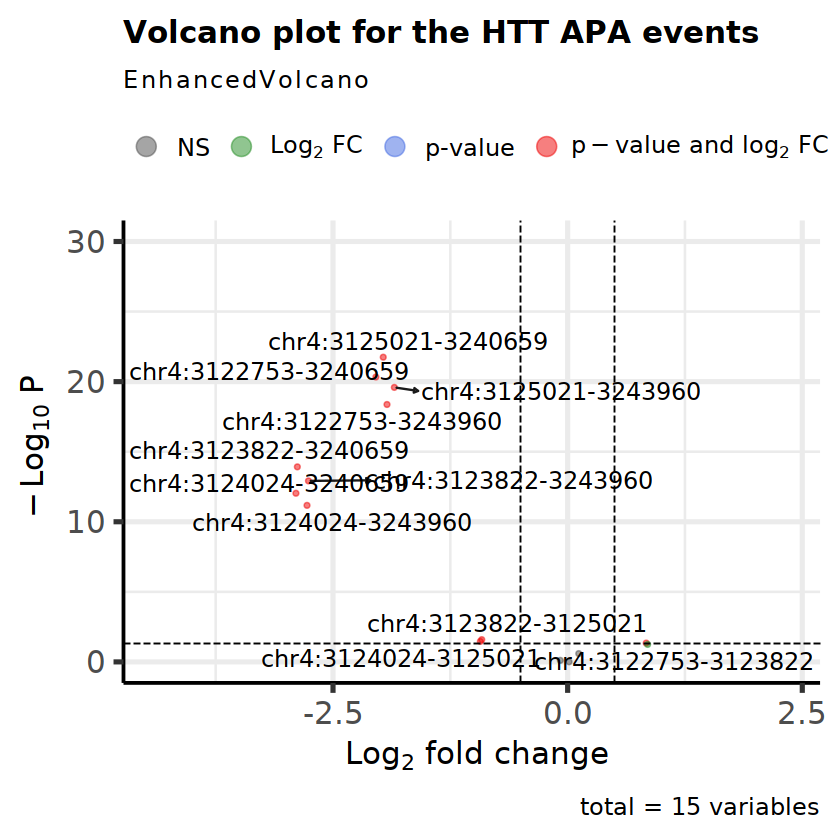

In [43]:
EnhancedVolcano(
    htt_res,
    lab = htt_res$ID,
    x = 'b_ConditionLILY283_treatment',
    y = 'p_ConditionLILY283_treatment',
    title = 'Volcano plot for the HTT APA events',
    pCutoff = 0.05,
    FCcutoff = .5,
    ylim = c(0, 30),
    pointSize = 1,
    drawConnectors = TRUE,
    )

In [44]:
# save the plot into pdf file
pdf("HTT_APAlog_2.pdf", width=10, height=10)
EnhancedVolcano(
    htt_res,
    lab = htt_res$ID,
    x = 'b_ConditionLILY283_treatment',
    y = 'p_ConditionLILY283_treatment',
    title = 'Volcano plot for the HTT APA events',
    pCutoff = 0.05,
    FCcutoff = .5,
    ylim = c(0, 30),
    pointSize = 1,
    drawConnectors = TRUE,
    )
dev.off()

png 
  2

In [53]:
genes_file <- read.csv("gene.txt", sep='\t')
head(genes_file)

,gene,npas,pval,RLDu,RLDi,REDu,REDu.pval,REDi,REDi.pval,nread.c1.1,nread.c1.2,nread.c2.1,nread.c2.2
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,PLEKHN1,2,6.48e-03,-0.35100,NA,-0.593,1.66e-03,NA,NA,218,353,293,150
2,B3GALT6,3,1.85e-26,-0.34200,NA,-0.650,1.97e-23,NA,NA,1915,2398,3415,2481
3,MIB2,2,3.15e-02,NA,-0.313,NA,NA,-0.313,9.52e-03,553,646,713,554
4,PRKCZ,2,6.57e-04,NA,1.690,NA,NA,1.690,8.18e-05,25,420,30,319
5,SKI,3,1.43e-04,-0.08020,NA,-0.714,4.87e-05,NA,NA,668,410,1037,277
6,RER1,5,1.23e-09,0.00707,NA,0.394,8.47e-10,NA,NA,4128,3221,4681,3856


In [16]:
# remove NA rows for REDi values
df <- genes_file[!is.na(genes_file$REDi),]

In [17]:
df$REDi.pval.adj <- p.adjust(df$REDi.pval, method = "fdr")
df <- df %>% filter(REDi.pval.adj < 0.05)
print(dim(df))
head(df)

[1] 3761   14


,gene,npas,pval,RLDu,RLDi,REDu,REDu.pval,REDi,REDi.pval,nread.c1.1,nread.c1.2,nread.c2.1,nread.c2.2,REDi.pval.adj
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,MIB2,2,3.15e-02,NA,-0.313,NA,NA,-0.313,9.52e-03,553,646,713,554,1.409557e-02
2,PRKCZ,2,6.57e-04,NA,1.690,NA,NA,1.690,8.18e-05,25,420,30,319,1.696316e-04
3,KCNAB2,4,1.17e-23,NA,-1.820,NA,NA,-2.520,1.92e-20,64,479,153,707,1.454088e-19
4,THAP3,2,1.00e-03,NA,0.745,NA,NA,0.745,3.17e-04,571,634,1169,1188,6.006442e-04
5,PER3,4,6.96e-29,NA,2.310,NA,NA,2.030,6.35e-17,316,321,772,320,3.978486e-16
6,SLC45A1,2,2.04e-11,NA,3.020,NA,NA,3.020,1.35e-12,93,86,249,70,6.310084e-12


Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”


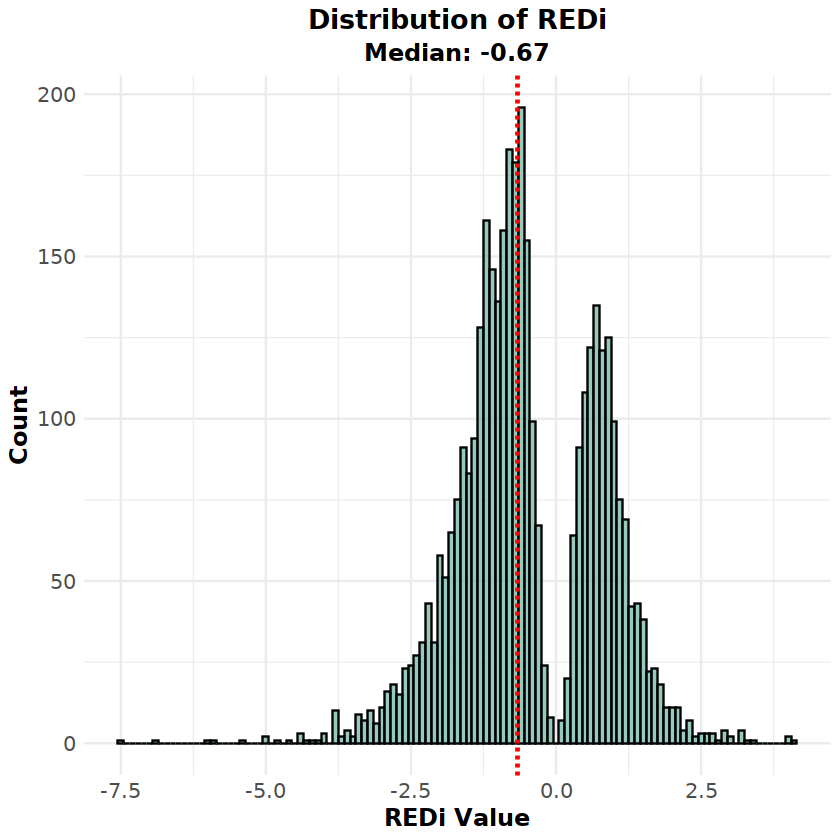

In [5]:
# Set theme for better appearance
theme_set(theme_bw())

# Calculate the median of REDi
median_REDi <- median(df$REDi, na.rm = TRUE)

# Create the histogram with a vertical line for the median
p <- ggplot(df, aes(x = REDi)) +
  geom_histogram(binwidth = 0.1, fill = "#69b3a2", color = "black", alpha = 0.7) + 
  geom_vline(aes(xintercept = median_REDi), color = "red", linetype="dashed", size=1) +
  labs(title = "Distribution of REDi",
       subtitle = paste("Median:", round(median_REDi, 2)), # Displaying the median value in subtitle
       x = "REDi Value",
       y = "Count") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face="bold", size=16),
    plot.subtitle = element_text(hjust = 0.5, face="bold", size=14),
    axis.title.x = element_text(face="bold", size=14),
    axis.title.y = element_text(face="bold", size=14),
    axis.text = element_text(size=12)
  )

# Display the plot
print(p)


In [7]:
head(df)

,gene,npas,pval,RLDu,RLDi,REDu,REDu.pval,REDi,REDi.pval,nread.c1.1,nread.c1.2,nread.c2.1,nread.c2.2,REDi.pval.adj
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,MIB2,2,3.15e-02,NA,-0.313,NA,NA,-0.313,9.52e-03,553,646,713,554,1.409557e-02
2,PRKCZ,2,6.57e-04,NA,1.690,NA,NA,1.690,8.18e-05,25,420,30,319,1.696316e-04
3,KCNAB2,4,1.17e-23,NA,-1.820,NA,NA,-2.520,1.92e-20,64,479,153,707,1.454088e-19
4,THAP3,2,1.00e-03,NA,0.745,NA,NA,0.745,3.17e-04,571,634,1169,1188,6.006442e-04
5,PER3,4,6.96e-29,NA,2.310,NA,NA,2.030,6.35e-17,316,321,772,320,3.978486e-16
6,SLC45A1,2,2.04e-11,NA,3.020,NA,NA,3.020,1.35e-12,93,86,249,70,6.310084e-12


In [18]:
df_org = df

In [27]:
# get rid of -inf and inf in REDi values
df <- df %>% filter(REDi != -Inf)
df <- df %>% filter(REDi != Inf)

In [ ]:
threshold <- 0.05
df$neglog10pval <- -log10(df$REDi.pval)
# Filter out rows where -log10pval is greater than 50 and where REDi is less than -5 or more than 5
df <- df[!df$neglog10pval > 50 & df$REDi > 5 & df$REDi < -5,]
df

In [35]:
# Threshold for significance
threshold <- 0.01
df$neglog10pval <- -log10(df$REDi.pval)
# Filter out rows where -log10pval is greater than 50 and where REDi is less than -5 or more than 5
# df <- df[!df$neglog10pval > 50 & df$REDi > 5 & df$REDi < -5,]

# Add a significance column based on p-value
df$significant <- ifelse(df$REDi.pval.adj < threshold, "Significant", "Not Significant")

# Add a category for lengthened and shortened
df$transcript_length <- ifelse(df$REDi > 0 & df$significant == "Significant", "Lengthened", 
                                ifelse(df$REDi < 0 & df$significant == "Significant", "Shortened", "Not Significant"))

# Create a subset of df for top 10 most significant and lengthened genes and top 10 most significant and shortened genes
top20_lengthened <- df[df$transcript_length == "Lengthened",] %>% arrange(desc(REDi)) %>% head(20)
top20_shortened <- df[df$transcript_length == "Shortened",] %>% arrange(REDi) %>% head(20)

In [74]:
df$significant <- ifelse(df$REDi.pval < threshold, "Significant", "Not Significant")
# Further categorize based on log2FC
df$significant <- ifelse(df$significant == "Significant" & abs(df$REDi) > 1, "Significant", "Not Significant")

df$transcript_length <- ifelse(df$REDi > 0 & df$significant == "Significant", "Lengthened", 
                                ifelse(df$REDi < 0 & df$significant == "Significant", "Shortened", "Not Significant"))

df <- df[!df$neglog10pval > 60 & df$REDi > -5 & df$REDi < 5,]

# Create a subset of df for top 10 most significant and lengthened genes and top 10 most significant and shortened genes
top20_lengthened <- df[df$transcript_length == "Lengthened",] %>% arrange(desc(REDi)) %>% head(20)
top20_shortened <- df[df$transcript_length == "Shortened",] %>% arrange(REDi) %>% head(20)
interested_genes <- c('HTT')
interested_genes_df <- df[df$gene %in% interested_genes,]
top_40 <- rbind(top20_lengthened, top20_shortened, interested_genes_df)

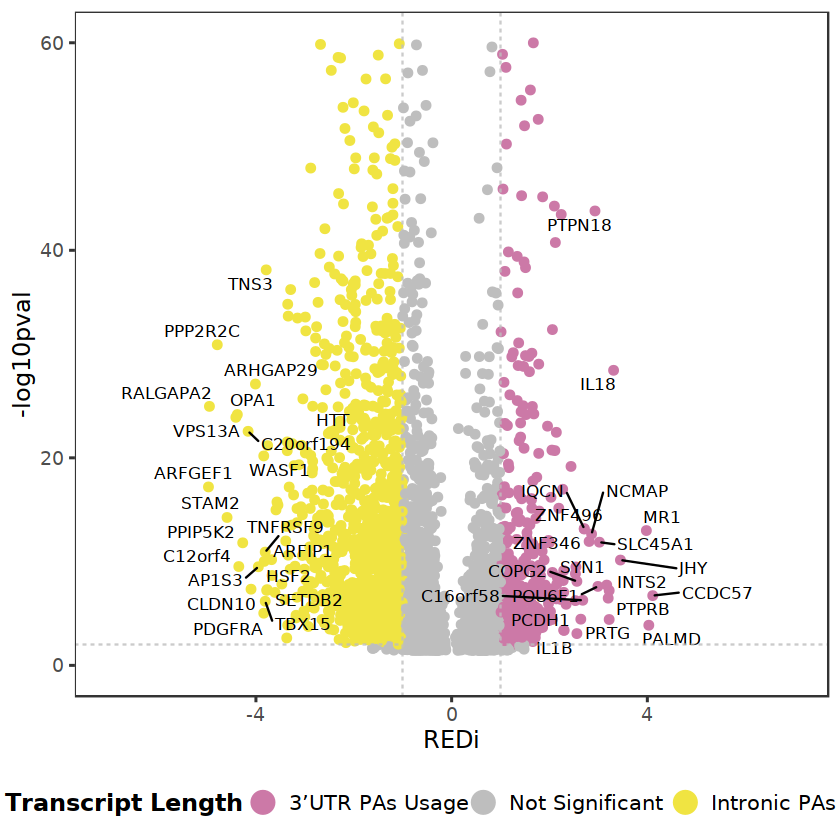

In [80]:
library(ggplot2)
library(dplyr)
library(ggrepel)

volcano_plot <- ggplot(df, aes(x=REDi, y=neglog10pval, color=transcript_length)) +
      geom_point(alpha=1, size=2) + 
      scale_color_manual(values=c("#CC79A7", "grey", "#F0E442"), labels=c("3’UTR PAs Usage", "Not Significant", "Intronic PAs Usage"), name = "Transcript Length") +
      theme_bw(base_size = 14) +  
      theme(panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            legend.position = "bottom",
            legend.box = "vertical",
            legend.title = element_text(size = 14, face='bold' ),  # Adjust legend text size here
            legend.text = element_text(size = 12),  # Adjust legend text size here
            plot.title = element_text(hjust = 0.5)) +
            guides(color=guide_legend(override.aes=list(size=6))) +
      xlab('REDi') + 
      ylab('-log10pval') + 
      geom_text_repel(data = top_40, aes(label = gene), size = 3.5, color='black',  max.overlaps=20) + 
      geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "grey", alpha = 0.8) +
      geom_hline(yintercept = -log10(threshold), linetype = "dashed", color = "grey", alpha = 0.8) +
      coord_cartesian(xlim = c(-7, 7), ylim=c(0,60)) # restrict x-axis and y-axis limits

volcano_plot

In [81]:
# save with ggsave
ggsave("/data1/HTT_APA/170828_D00331_0257_BCBC0YANXX_Pugh_Laura/MAAPER_out_2/PAs_REDi_Usage_volcano_plot_2.pdf", width=10, height=10, units = "in", dpi = 300)

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '3’UTR PAs Usage' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '3’UTR PAs Usage' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '3’UTR PAs Usage' in 'mbcsToSbcs': dot substituted for <99>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '3’UTR PAs Usage' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '3’UTR PAs Usage' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '3’UTR PAs Usage' in 'mbcsToSbcs': dot substituted for <99>”
Warn

In [77]:
# save df into csv file
write.csv(df, file = "/data1/HTT_APA/170828_D00331_0257_BCBC0YANXX_Pugh_Laura/MAAPER_out_2/REDi_Usage.csv", row.names = FALSE)